### Datasets
    - gdsc --> gg
    - ctrp --> cc
### Models
    - lgb
    - nn0
    - nn1

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from load_modules import *
%matplotlib inline
fpath = Path(os.getcwd())
print('Current path:', fpath)

outpath = fpath/'outpath'
os.makedirs(outpath, exist_ok=True)

Current path: /vol/ml/apartin/projects/dr-learning-curves/nbs


## Path to data

In [2]:
fname = 'all_scores.csv'
dpath = Path('../lc.out')
# dirs = sorted(dpath.glob('*'))
dirs = glob(str(dpath/'*'))
print(dirs)

[PosixPath('../lc.out/.ipynb_checkpoints'), PosixPath('../lc.out/lc.ctrp.lgb.default'), PosixPath('../lc.out/lc.ctrp.nn_attn1.test'), PosixPath('../lc.out/lc.ctrp.nn_reg0.test'), PosixPath('../lc.out/lc.ctrp.nn_reg1.test'), PosixPath('../lc.out/lc.gdsc.lgb.default'), PosixPath('../lc.out/lc.gdsc.nn_reg0.test'), PosixPath('../lc.out/lc.gdsc.nn_reg1.test')]


In [3]:
c_lgb_path = dpath/'lc.ctrp.lgb.default'/fname
# c_lgb_path = dpath/dirs[0]/fname
# g_lgb_path = dpath/dirs[1]/fname

## Load data

In [4]:
data = load_data(c_lgb_path, tr_set='te'); src='CTRP'; model='LGBM'
print('data.shape', data.shape)
# g_lgb = load_data(g_lgb_path)

data.shape (12960, 5)


## Raw plots

In [5]:
# Global plotting params
# ----------------------
met = 'mean_absolute_error'
t_set = 'te'
xtick_scale = 'log2'
ytick_scale = 'log2'
kwargs = {'metric_name': met, 'tr_set': t_set, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale, 'plot_median': True}

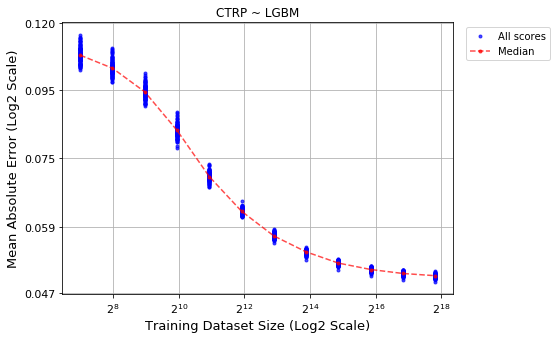

In [6]:
# Plot all raw
# -------------------------------
kwargs.update({'title': f'{src} ~ {model}'})
ax = lc_plots.plot_lc_single_metric(data, **kwargs);

In [7]:
df = data[ data['metric']==met ].reset_index(drop=True)
print(f'Total points for {met}: {len(df)}')

Total points for mean_absolute_error: 1440


## Fit and extrapolate

In [12]:
# ----------------
# Prepare the data
# ----------------
df = data.copy()
df = df[ df['metric']==met ].reset_index(drop=True)
print('Raw dataset of scores', df.shape)

# Agg scores
df['y'] = df['score']
df = df[df['metric']==met].groupby('tr_size').agg({'y': 'median'}).reset_index()
print('Agg with median', df.shape)

# Split dfit and dext
x_fit_mn = 1000
x_fit_mx = 40000

dfit = subset_data(df, col='tr_size', x_mn=x_fit_mn, x_mx=x_fit_mx)
dext = subset_data(df, col='tr_size', x_mn=x_fit_mx, x_mx=None)
dfit = add_weight_col(dfit)

print('dfit.shape:', dfit.shape)
print('dext.shape:', dext.shape)
print('Train size (dfit):', dfit['tr_size'].unique())
print('Train size (dext):', dext['tr_size'].unique())

Raw dataset of scores (1440, 5)
Agg with median (12, 2)
dfit.shape: (5, 3)
dext.shape: (3, 2)
Train size (dfit): [ 1954  3862  7635 15093 29835]
Train size (dext): [ 58976 116578 230441]


In [13]:
# # Fit and extrap (nlsLM)
# # ----------------------------------
# # Use each set of the extreme points to fit a model
# coefs = fit_model(dfit['tr_size'], dfit['y'], dfit['w'])
# dfit['fit'] = calc_fit(dfit['tr_size'], coefs)
# dext['fit'] = calc_fit(dext['tr_size'], coefs)
# print(dfit['fit'].values)
# print(dext['fit'].values)

# # Fit and extrap (old)
# # ----------------------------------
# # prms = fit_params(x=dfit['tr_size'].values, y=dfit['y'].values)
# # yf = biased_powerlaw(dfit['tr_size'].values, **prms)
# # ye = biased_powerlaw(dext['tr_size'].values, **prms)
# # print(yf)
# # print(ye)

In [14]:
# ax = None

# pnts_args = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale, 'alpha': 0.5, 'ls': '', 'marker': '.'}
# fit_args = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale, 'alpha': 0.5, 'ls': '--', 'marker': ''}

# xf = dfit['tr_size'].values
# xe = dext['tr_size'].values
# yf_raw = dfit['y'].values
# ye_raw = dext['y'].values
# yf_fit = dfit['fit'].values
# ye_fit = dext['fit'].values

# # Raw data
# ax = lc_plots.plot_lc(x=xf, y=yf_raw, ax=ax, **pnts_args, color='b', label='dfit data')
# ax = lc_plots.plot_lc(x=xe, y=ye_raw, ax=ax, **pnts_args, color='r', label='dext data')

# # Fits
# ax = lc_plots.plot_lc(x=xf, y=yf_fit, ax=ax, **fit_args, color='b', label='dfit fit')
# ax = lc_plots.plot_lc(x=xe, y=ye_fit, ax=ax, **fit_args, color='r', label='dext fit')

# ax.set_title(f'{src} ~ {model}')
# ax.legend(frameon=True, fontsize=10, loc='best')
# ax.grid(False)

In [15]:
pnts_args = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale, 'alpha': 0.5, 'ls': '', 'marker': '.'}
fit_args = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale, 'alpha': 0.5, 'ls': '--', 'marker': ''}

xf = dfit['tr_size'].values
xe = dext['tr_size'].values
yf = dfit['y'].values
ye = dext['y'].values

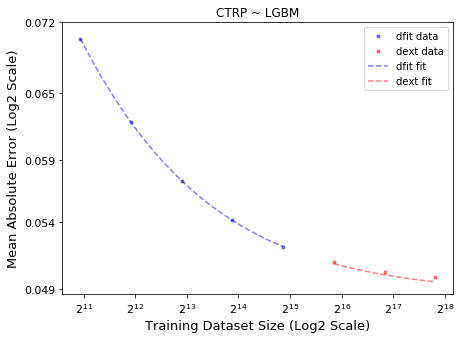

In [17]:
cc = FitPwrLaw(xf=dfit['tr_size'].values, yf=dfit['y'].values, w=dfit['w'].values)
xf_plot, yf_plot = cc.calc_fit( x1=xf[0], x2=xf[-1] )
xe_plot, ye_plot = cc.calc_fit( x1=xe[0], x2=xe[-1] )

# Reset axes
ax = None

# Raw data
ax = lc_plots.plot_lc(x=xf, y=yf, ax=ax, **pnts_args, color='b', label='dfit data')
ax = lc_plots.plot_lc(x=xe, y=ye, ax=ax, **pnts_args, color='r', label='dext data')

# Fits
ax = lc_plots.plot_lc(x=xf_plot, y=yf_plot, ax=ax, **fit_args, color='b', label='dfit fit')
ax = lc_plots.plot_lc(x=xe_plot, y=ye_plot, ax=ax, **fit_args, color='r', label='dext fit')

ax.set_title(f'{src} ~ {model}')
ax.legend(frameon=True, fontsize=10, loc='best')
ax.grid(False)

In [18]:
cc.coefs

,coef,est,se,t_val,p_val
0,a,3.577894,0.345547,10.354282,0.009199
1,b,-0.673947,0.013185,-51.115241,0.000383
2,c,0.048638,0.000156,311.194123,0.000010


## Filtering

df.shape (2880, 5)


,run,tr_size,set,metric,score
0,run_104,128,te,r2,0.052339
1,run_104,253,te,r2,0.066318


df.shape (1082, 5)


,run,tr_size,set,mean_absolute_error,r2
0,run_0,988,te,0.081754,0.381946
1,run_0,1954,te,0.070105,0.541345


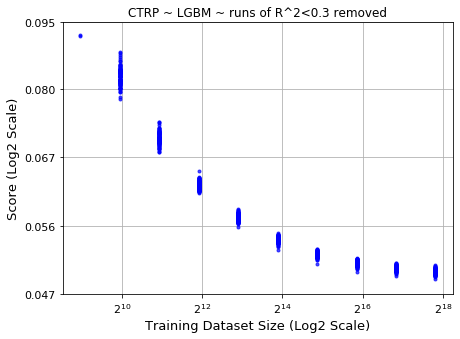

In [8]:
# Remove scores (trainings that didn't converg)
# ---------------------------------------------
df = data.copy()

r2_th = 0.3
df = df[(df['metric']==met) | (df['metric']=='r2')].reset_index(drop=True)
print('df.shape', df.shape)
display(df[:2])

df = pd.pivot_table(df, values='score', index=['run', 'tr_size', 'set'], columns='metric').reset_index()
df.columns.name = None
df = df[ df['r2']>r2_th ].reset_index(drop=True)
print('df.shape', df.shape)
display(df[:2])

x = df['tr_size'].values
y = df[met].values
lc_plots.plot_lc(x, y, ls='', title=f'{src} ~ {model} ~ runs of R^2<{r2_th} removed');

df.shape (1440, 5)


,tr_size,med,sd,sd_top
0,128,0.107185,0.002965,0.110150
1,253,0.102445,0.002529,0.104974
2,500,0.094382,0.002214,0.096597
3,988,0.082567,0.001855,0.084422
4,1954,0.070310,0.001103,0.071413
5,3862,0.062341,0.000626,0.062967
6,7635,0.057225,0.000505,0.057730
7,15093,0.054146,0.000403,0.054550
8,29835,0.052078,0.000340,0.052418
9,58976,0.050933,0.000327,0.051260


df.shape (1199, 7)


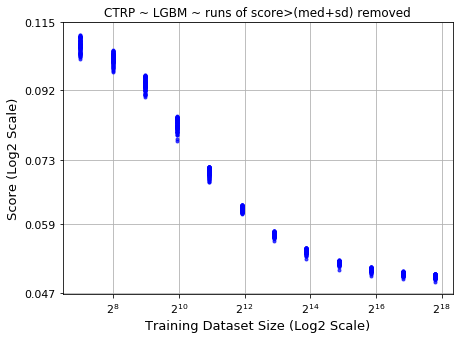

In [9]:
# Remove vertical 'outliers' (filter on std)
# ------------------------------------------
df = data.copy()
df = df[ df['metric']==met ].reset_index(drop=True)
print('df.shape', df.shape)

# Agg scores
agg = df.copy()
agg['sd'] = agg['score']
agg['med'] = agg['score']
agg = agg[agg['metric']==met].groupby('tr_size').agg({'med': 'median', 'sd': 'std'}).reset_index()
agg['sd_top'] = agg['med'] + agg['sd']
display(agg)

# Filter on sd
dct = { agg.loc[i, 'tr_size']: agg.loc[i, 'sd_top'] for i in range(len(agg)) } # key: tr_size, value: sd_top
df['sd_top'] = df['tr_size'].map(lambda x: dct[x])
df['good_sd'] = [True if df.loc[i,'score'] <= df.loc[i,'sd_top'] else False for i in range(len(df))]
df = df[ df['good_sd']==True ].reset_index(drop=True)
print('df.shape', df.shape)

x = df['tr_size'].values
y = df['score'].values
lc_plots.plot_lc(x, y, ls='', title=f'{src} ~ {model} ~ runs of score>(med+sd) removed');

## Fitting

In [10]:
# p_value_min = 0.05
p_value_min = 0.2

In [11]:
# Split dfit and dext
# -------------------
df = data.copy()
df = df[ df['metric']==met ].reset_index(drop=True)

x_fit_mn = 200
x_fit_mx = 40000

dfit = subset_data(df, col='tr_size', x_mn=x_fit_mn, x_mx=x_fit_mx)
dext = subset_data(df, col='tr_size', x_mn=x_fit_mx, x_mx=None)
dfit = add_weight_col(dfit)

print('dfit.shape:', dfit.shape)
print('dext.shape:', dext.shape)

print('Train size (dfit):', dfit['tr_size'].unique())
print('Train size (dext):', dext['tr_size'].unique())

dfit.shape: (960, 6)
dext.shape: (360, 5)
Train size (dfit): [  253   500   988  1954  3862  7635 15093 29835]
Train size (dext): [ 58976 116578 230441]


In [12]:
# Fit single run
# --------------
# run_name = 'run_104'
# data_fit = dfit[ dfit['run'] == run_name ].reset_index(drop=True)
# display(data_fit)

# xf = data_fit['tr_size'].values
# yf = data_fit['score'].values
# w  = data_fit['w'].values
# coef_est = fit_model(xf, yf, w)

# coef_est['valid'] = coef_est['p_val'].map(lambda x: True if x <= p_value_min else False)
# coef_est['run'] = run_name
# coef_est

In [13]:
# Fit model for each run (set of samples)
# ---------------------------------------
coef_est_df = []
for run_name in dfit['run'].unique():
    data_fit = dfit[ dfit['run'] == run_name ].reset_index(drop=True)
    
    # At least 3 fitting points are required
    if len(data_fit) < 4: continue
        
    xf = data_fit['tr_size'].values
    yf = data_fit['score'].values
    w  = data_fit['w'].values
    coef_est = fit_model(xf, yf, w)
    
    coef_est['valid'] = coef_est['p_val'].map(lambda x: True if x <= p_value_min else False)
    coef_est['run'] = run_name
    
    coef_est_df.append(coef_est)
    
coef_est_df = pd.concat(coef_est_df, axis=0).reset_index(drop=True)
print('coef_est_df.shape', coef_est_df.shape)
display( coef_est_df[:3] )

R[write to console]: Loading required package: dplyr

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: tibble

R[write to console]: Loading required package: minpack.lm



coef_est_df.shape (360, 7)


,coef,est,se,t_val,p_val,valid,run
0,a,1.072827,0.259563,4.133207,9.056669e-03,True,run_104
1,b,-0.501116,0.040603,-12.341905,6.184719e-05,True,run_104
2,c,0.045830,0.001311,34.956259,3.604779e-07,True,run_104


In [14]:
# Determine runs with good and bad runs fits
# ------------------------------------------
dfit['fit'] = -100
dext['fit'] = -100

for run_name in dfit['run'].unique():
    # Get the sizes and coefs for a run
    coefs = coef_est_df.loc[coef_est_df['run'] == run_name, :].reset_index(drop=True)
    
    # Skip fits if "valid" are NaN
    if coefs['valid'].isna().sum() == 3: continue
    
    # Skip fits with bad estimates
    if coefs['valid'].sum() != 3: continue

    # Est scores
    ids = dfit['run'] == run_name
    dfit.loc[ids, 'fit'] = calc_fit(dfit.loc[ids,'tr_size'].values, coefs)

    ids = dext['run'] == run_name
    dext.loc[ids, 'fit'] = calc_fit(dext.loc[ids,'tr_size'].values, coefs)

In [15]:
# Good and bad runs based for dfit
# --------------------------------
bad_ids = dfit['fit'] == -100
dfit_bad = dfit.loc[bad_ids, :]
dfit_good = dfit.loc[~bad_ids, :]
bad_runs = dfit_bad['run'].unique()
good_runs = dfit_good['run'].unique()

print(dfit_bad.shape)
print(dfit_good.shape)

# Good and bad runs based for dext
# --------------------------------
# dext_bad <- dext[dext$fit==-100,]
# dext_ <- dext[dext$fit>-100,]
# good_run_ext <- as.vector(unique(dext_$run))
# bad_run_ext <- as.vector(unique(dext_bad$run))

(0, 7)
(960, 7)


In [17]:
plot_args = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale, 'alpha': 0.3, 'ls': '', 'marker': '.'}

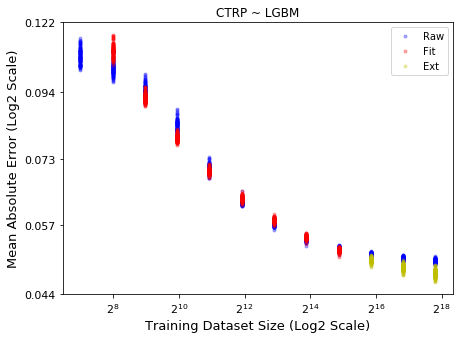

In [18]:
ax = None

df = data[data['metric']==met].reset_index(drop=True)
x = df['tr_size'].values
y = df['score'].values
ax = lc_plots.plot_lc(x=x, y=y, ax=ax, **plot_args, color='b', label='Raw')

x = dfit['tr_size'].values
y = dfit['fit'].values
ax = lc_plots.plot_lc(x=x, y=y, ax=ax, **plot_args, color='r', label='Fit')

x = dext['tr_size'].values
y = dext['fit'].values
ax = lc_plots.plot_lc(x=x, y=y, ax=ax, **plot_args, color='y', label='Ext')

ax.set_title(f'{src} ~ {model}')
ax.legend(frameon=True, fontsize=10, loc='best')
ax.grid(False)

## Calc CI

In [19]:
# Find the extreme points per tr_sz (min and max)
# -----------------------------------------------

# Method 1
# --------
# dfit_pivot = pd.pivot_table(dfit, values='score', index=['tr_size'], columns='run').reset_index()
# dfit_pivot.columns.name = None

# df = dfit_pivot.copy()
# ci_lwr = pd.DataFrame({'tr_size': df['tr_size'].values, 'y': df.iloc[:,1:].min(axis=1)})
# ci_upr = pd.DataFrame({'tr_size': df['tr_size'].values, 'y': df.iloc[:,1:].max(axis=1)})
# ci_lwr = add_weight_col(ci_lwr)
# ci_upr = add_weight_col(ci_upr)

# Method 2
# --------
ci_lwr = dfit[['tr_size', 'score']]
ci_lwr = ci_lwr.groupby('tr_size').agg({'score': 'min'}).reset_index().rename(columns={'score': 'y'})
ci_lwr = add_weight_col(ci_lwr)

ci_upr = dfit[['tr_size', 'score']]
ci_upr = ci_upr.groupby('tr_size').agg({'score': 'max'}).reset_index().rename(columns={'score': 'y'})
ci_upr = add_weight_col(ci_upr)

In [20]:
# Calc CI (using the extreme points)
# ----------------------------------
# Use each set of the extreme points to fit a model
ci_lwr_coefs = fit_model(ci_lwr['tr_size'], ci_lwr['y'], ci_lwr['w'])
ci_upr_coefs = fit_model(ci_upr['tr_size'], ci_upr['y'], ci_upr['w'])
ci_lwr['fit'] = calc_fit(ci_lwr['tr_size'], ci_lwr_coefs)
ci_upr['fit'] = calc_fit(ci_upr['tr_size'], ci_upr_coefs)


In [22]:
# Extrapolate CI curves
# ---------------------
ci_lwr_ext = pd.DataFrame( {'tr_size': dext['tr_size'].unique()} )
ci_upr_ext = pd.DataFrame( {'tr_size': dext['tr_size'].unique()} )
ci_lwr_ext['fit'] = calc_fit(ci_lwr_ext['tr_size'], ci_lwr_coefs)
ci_upr_ext['fit'] = calc_fit(ci_upr_ext['tr_size'], ci_upr_coefs)

In [23]:
pnts_args = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale, 'alpha': 0.3, 'ls': '', 'marker': '.'}
ci_args = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': ytick_scale, 'alpha': 0.3, 'ls': '--', 'marker': '.'}

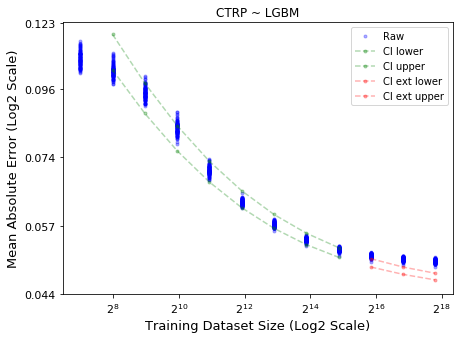

In [24]:
ax = None

df = data[data['metric']==met].reset_index(drop=True)
x = df['tr_size'].values
y = df['score'].values
ax = lc_plots.plot_lc(x=x, y=y, ax=ax, **pnts_args, color='b', label='Raw')

x = ci_lwr['tr_size'].values
y = ci_lwr['fit'].values
ax = lc_plots.plot_lc(x=x, y=y, ax=ax, **ci_args, color='g', label='CI lower')

x = ci_upr['tr_size'].values
y = ci_upr['fit'].values
ax = lc_plots.plot_lc(x=x, y=y, ax=ax, **ci_args, color='g', label='CI upper')

x = ci_lwr_ext['tr_size'].values
y = ci_lwr_ext['fit'].values
ax = lc_plots.plot_lc(x=x, y=y, ax=ax, **ci_args, color='r', label='CI ext lower')

x = ci_upr_ext['tr_size'].values
y = ci_upr_ext['fit'].values
ax = lc_plots.plot_lc(x=x, y=y, ax=ax, **ci_args, color='r', label='CI ext upper')

ax.set_title(f'{src} ~ {model}')
ax.legend(frameon=True, fontsize=10, loc='best')
ax.grid(False)